<a href="https://colab.research.google.com/github/cris-her/AI/blob/master/dnn_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn #neural networks
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt

# Construyendo un modelo

In [2]:
data_path = 'data/'

full_data_set = datasets.CIFAR10(data_path, train=True, download=True,
                                 transform = transforms.Compose(
                                    [transforms.ToTensor(),
                                    transforms.Normalize((0.4915, 0.4823, 0.4468), 
                                                         (0.2470, 0.2435, 0.2616))
                                  ]))





full_validation_set = datasets.CIFAR10(data_path, train=False, download=True, 
                                  transform = transforms.Compose(
                                  [transforms.ToTensor(),
                                  transforms.Normalize((0.4915, 0.4823, 0.4468), 
                                                       (0.2470, 0.2435, 0.2616))
                                ]))

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [3]:
# Vamos a usar un dataloader para cargar los datos en un tamaño de batch especifico
size = 4
dataloader = torch.utils.data.DataLoader(full_data_set, batch_size=size, shuffle = True, num_workers=2)

In [4]:
len(full_data_set)

50000

In [5]:
len(full_validation_set)

10000

Vamos a crear un iterador sobre  el data loader para obtener las imagenes y las etiquetas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane
plane
deer
bird


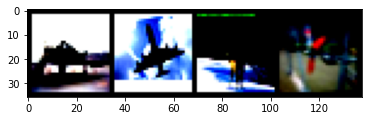

In [6]:
data_iterator = iter(dataloader)
imgs, labels = data_iterator.next()

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(utils.make_grid(imgs).permute(1, 2,0))

for i in range(size):
  print(classes[labels[i]])

De todo este dataset nos vamos a quedar unicamente con dos clases: car (posicion 1) y cat (posicion 3), y vamos a crear un nuevo dataset 

In [7]:
class_names = ['car', 'cat']

label_map = {1: 0, 3: 1}

data_set = [(img, label_map[label]) for img, label in full_data_set if label in [1,3]]
validation_set = [(img, label_map[label]) for img, label in full_validation_set if label in [1,3]]

In [8]:
img, label = data_set[20]
img.shape

torch.Size([3, 32, 32])

Vamos a crear un modelo basado en una transformacion lineal de 32 x 32 x 3, ya que estamos intentando realizar una red neuronal, debemos utilizar una funcion de activacion, arbitrariamente usaremos una tangente hiperbolica **tanH**, pero haremos varias pruebas para ver que nos funciona mejor, luego de tanH vamos a tener una salida que necesitamos sea un resultado de un clasificador binario.

In [9]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2)
)

El resultado final debe ser una probabilidad, por lo que puedo trabajar con el sigmoide o con softmax (vemos ejemplo)

In [10]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum()

In [11]:
x = torch.tensor([1.0, 2.0, 3.0])

In [12]:
softmax(x).sum()
# La suma de cada evaluacion nos da 1

tensor(1.)

Agregamos al modelo la funcion softmax de pytorch

In [13]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1) # Usamos mas de una variable
)

Aplicamos el modelo a la imagen 20 del dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


this image is a car


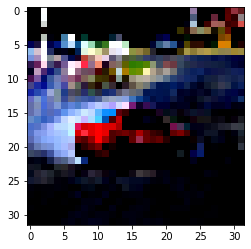

In [14]:
img, label = data_set[20]
plt.imshow(img.permute(1, 2, 0))
print(f'this image is a {class_names[label]}')

In [15]:
out =model(img.view(-1).unsqueeze(0))
out

tensor([[0.4631, 0.5369]], grad_fn=<SoftmaxBackward>)

Obtenemos la posicion del indice con torch.max() en el dataset para la prediccion

In [16]:
_, index = torch.max(out, dim=1) 
print('train dataset:', class_names[label], '| model:', class_names[index])

train dataset: car | model: cat


# Implementando un clasificador totalmente conectado




En esta seccion vamos a cambiar Softmax por una funcion logaritmica dadas sus limitantes

In [17]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


this image is a car


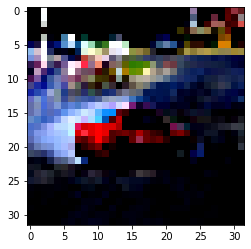

In [18]:
img, label = data_set[20]
plt.imshow(img.permute(1, 2, 0))
print(f'this image is a {class_names[label]}')

In [19]:
out = model(img.view(-1).unsqueeze(0))
print(out)

print('train dataset:', class_names[label], '| model:', class_names[index])

tensor([[-0.7146, -0.6722]], grad_fn=<LogSoftmaxBackward>)
train dataset: car | model: cat


Creamos un loop de entrenamiento

In [20]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 5 #iteraciones

for epoch in range(n_epochs):
  for img, label in data_set:
    out = model(img.view(-1).unsqueeze(0))
    loss = loss_function(out, torch.tensor([label]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.011598535813391209
Eoch: 1, Loss: 0.0029223139863461256
Eoch: 2, Loss: 0.00018463814922142774
Eoch: 3, Loss: 2.738476037979126
Eoch: 4, Loss: 0.8798630833625793


In [21]:
# Haciendo uno del train_loader
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 100 #iteraciones

for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0], -1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.7981480956077576
Eoch: 1, Loss: 0.38919055461883545
Eoch: 2, Loss: 0.3137369453907013
Eoch: 3, Loss: 0.13955727219581604
Eoch: 4, Loss: 0.6608052849769592
Eoch: 5, Loss: 0.1853976547718048
Eoch: 6, Loss: 0.3408593237400055
Eoch: 7, Loss: 0.936850905418396
Eoch: 8, Loss: 0.8437159061431885
Eoch: 9, Loss: 0.2870207726955414
Eoch: 10, Loss: 0.49025794863700867
Eoch: 11, Loss: 0.27423983812332153
Eoch: 12, Loss: 0.2681231200695038
Eoch: 13, Loss: 0.2755594849586487
Eoch: 14, Loss: 0.2803255021572113
Eoch: 15, Loss: 0.14475277066230774
Eoch: 16, Loss: 0.34893858432769775
Eoch: 17, Loss: 0.3096768260002136
Eoch: 18, Loss: 0.2661784887313843
Eoch: 19, Loss: 0.11490392684936523
Eoch: 20, Loss: 0.14385369420051575
Eoch: 21, Loss: 0.057695839554071426
Eoch: 22, Loss: 0.09106038510799408
Eoch: 23, Loss: 0.18689198791980743
Eoch: 24, Loss: 0.12779565155506134
Eoch: 25, Loss: 0.13341204822063446
Eoch: 26, Loss: 0.06085164099931717
Eoch: 27, Loss: 0.15740245580673218
Eoch: 28, Loss:

In [22]:
# Validamos el loss
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())

print("Accuracy: %f"% (correct / total))     

Accuracy: 0.874000


In [23]:
img, label = validation_set[20]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
out

tensor([[-3.3378e-05, -1.0308e+01]], grad_fn=<LogSoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->:  car  model: car


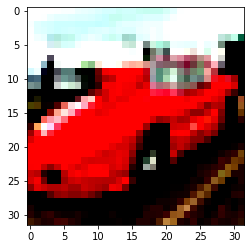

In [24]:
print('->: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Mejoras, limitaciones y conclusiones

In [25]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024), #3072 = 3*32*32 
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2),

)

#LogSoftmax tiene un efecto CrossEntropyLoss
loss_function = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 100 #iteraciones

for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0], -1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.4784146249294281
Eoch: 1, Loss: 0.5297339558601379
Eoch: 2, Loss: 0.30498120188713074
Eoch: 3, Loss: 0.30666667222976685
Eoch: 4, Loss: 0.20819248259067535
Eoch: 5, Loss: 0.4358029067516327
Eoch: 6, Loss: 0.3289766311645508
Eoch: 7, Loss: 0.15222826600074768
Eoch: 8, Loss: 0.27457311749458313
Eoch: 9, Loss: 0.2518095076084137
Eoch: 10, Loss: 0.266091525554657
Eoch: 11, Loss: 0.26826509833335876
Eoch: 12, Loss: 0.17525827884674072
Eoch: 13, Loss: 0.21480593085289001
Eoch: 14, Loss: 0.10604345053434372
Eoch: 15, Loss: 0.2675420641899109
Eoch: 16, Loss: 0.2905176281929016
Eoch: 17, Loss: 0.19976942241191864
Eoch: 18, Loss: 0.16239158809185028
Eoch: 19, Loss: 0.08500850945711136
Eoch: 20, Loss: 0.12642021477222443
Eoch: 21, Loss: 0.23014028370380402
Eoch: 22, Loss: 0.04110947251319885
Eoch: 23, Loss: 0.06363316625356674
Eoch: 24, Loss: 0.10527723282575607
Eoch: 25, Loss: 0.16920727491378784
Eoch: 26, Loss: 0.11040087044239044
Eoch: 27, Loss: 0.0886845737695694
Eoch: 28, Lo

In [26]:
# Validamos el loss
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())

print("Accuracy: %f"% (correct / total)) 

Accuracy: 1.000000


Nos encontramos con un modelo con overfiting sobre entrenado

In [27]:
### realizamos una suma de parametros (pesos)
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

El numero de parametros es muy grande para un dataset tan pequeño


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: car   model: cat


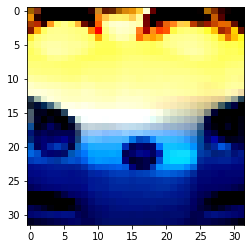

In [28]:
image = request.urlretrieve('https://i.pinimg.com/originals/43/bc/47/43bc47066bb8b2fa4fe7cc8e82cc3714.jpg','test,jpg')
                            
img = Image.open(image[0])

preprocess = transforms.Compose([
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616]
        )])

img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: car ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))

Subir un grado de mejora seria trabajar con convulucion